# LLM Chess Battle

### Tijek projekta:
- Istraživanje:
    - [Leaderboard 1](https://maxim-saplin.github.io/llm_chess/)
    - [Leaderboard 2](https://dubesor.de/chess/chess-leaderboard)
    - [Chess Arena](https://github.com/llm-chess-arena/llm-chess-arena/)
    - [ai4free](https://github.com/Devs-Do-Code/ai4free)
- Implementacija:
    - okruženje - Python, Jupyter
    - implementacija upravljanja okruženjem u direktoriju `enviroment_setup`
    - implementacija API poziva za određene agente (svaki u svojoj grani, **selekcija po kvaliteti odgovora**)
    - implementacija agent wrapper klase
    - implementacija igre
    <br>
    ```bash
     python -m test.game_test
     python -m test.user_game_test
    ```
    - implementacija spremanja i log ilegalnih poteza
    - implementacija vođenja turnira
    - prvi pokušaj turnira - problem - prekidanje partije zbog token/request limita providera
    - poboljšanje implementacije turnira - dodavanje provjere za ERROR response od LLM-a, spremanje i učitavanje stanja turnira
    - implementacija pomoći LLM-u (array ponuđenih poteza u slučaju da je prvi put pogriješio) -> Rezultat: **gotovo 99% legalnih poteza**
    - drugo pokretanje turnira (double round-robin system, 5 LLM-ova, 40 partija)
    - prikupljeni svi .pgn (Portable Game Notation) i log fileovi
    - dijelom automatska, a dijelom manualna izrada .csv datoteke sa informacijama iz partija -> `analysis/data/chess_analysis.csv`
    - analiza partija u jupyter bilježnici -> `analysis/notebooks/llm_chess_analysis.ipynb`


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

In [23]:
data = pd.read_csv('..\data\chess_analysis.csv', delimiter=';')

In [24]:
data.shape

(40, 35)

In [25]:
data.head()

,game_id,white,black,date,game,result,opening,eco_code,white_brilliant_moves,black_brilliant_moves,...,black_theoretical_moves,white_move_accuracy,black_move_accuracy,termination_by,white_illegal_moves,black_illegal_moves,white_illegal_streak_max,black_illegal_streak_max,white_random_fallbacks,black_random_fallbacks
0,gemini_vs_cohere_20260128151848,gemma-3-27b-it,command-a-03-2025,28.1.2026,0,1/2-1/2,Petrov's Defence,C42,0,0,...,3,"56,7","55,7",repetition,18,23,2,5,0,1
1,gemini_vs_groq_20260128153558,gemma-3-27b-it,llama-3.3-70b-versatile,28.1.2026,1,0-1,Scandinavian Defence,B01,0,0,...,1,"41,4","41,7",checkmate,40,33,5,2,1,0
2,gemini_vs_reka_20260128160139,gemma-3-27b-it,reka-core-20240501,28.1.2026,2,1/2-1/2,King's Pawn Game,C44,0,0,...,2,"67,6","74,6",repetition,6,3,3,1,0,0
3,gemini_vs_youchat_20260128160619,gemma-3-27b-it,youchat,28.1.2026,3,1/2-1/2,King's Pawn Game,C44,0,0,...,1,54,"54,2",repetition,44,16,18,2,5,0
4,cohere_vs_gemini_20260128213149,command-a-03-2025,gemma-3-27b-it,28.1.2026,4,1/2-1/2,Petrov's Defence,C42,0,0,...,2,"81,2","78,3",repetition,27,26,2,2,0,0


In [26]:
print("Columns in the dataset:")
for col in data.columns:
    print(col)

Columns in the dataset:
game_id
white
black
date
game
result
opening
eco_code
white_brilliant_moves
black_brilliant_moves
white_critical_moves
black_critical_moves
white_best_moves
black_best_moves
white_excellent_moves
black_excellent_moves
white_ok_moves
black_ok_moves
white_inaccuracies
black_inaccuracies
white_mistakes
black_mistakes
white_blunders
black_blunders
white_theoretical_moves
black_theoretical_moves
white_move_accuracy
black_move_accuracy
termination_by
white_illegal_moves
black_illegal_moves
white_illegal_streak_max
black_illegal_streak_max
white_random_fallbacks
black_random_fallbacks


In [27]:
print(f"Total number of games: {data.shape[0]}")

Total number of games: 40


In [28]:
print("Missing values per column:")
print(data.isnull().sum())

Missing values per column:
game_id                     0
white                       0
black                       0
date                        0
game                        0
result                      0
opening                     0
eco_code                    5
white_brilliant_moves       0
black_brilliant_moves       0
white_critical_moves        0
black_critical_moves        0
white_best_moves            0
black_best_moves            0
white_excellent_moves       0
black_excellent_moves       0
white_ok_moves              0
black_ok_moves              0
white_inaccuracies          0
black_inaccuracies          0
white_mistakes              0
black_mistakes              0
white_blunders              0
black_blunders              0
white_theoretical_moves     0
black_theoretical_moves     0
white_move_accuracy         0
black_move_accuracy         0
termination_by              0
white_illegal_moves         0
black_illegal_moves         0
white_illegal_streak_max    0
black_illegal

In [29]:
data['white_move_accuracy'] = data['white_move_accuracy'].str.replace(',', '.').astype(float)
data['black_move_accuracy'] = data['black_move_accuracy'].str.replace(',', '.').astype(float)
print("Converted 'white_move_accuracy' and 'black_move_accuracy' to numeric.")

Converted 'white_move_accuracy' and 'black_move_accuracy' to numeric.


In [30]:
all_agents = pd.concat([data['white'], data['black']]).unique()
print("Unique agents:")
for agent in all_agents:
    print('\n' + agent )

Unique agents:

gemma-3-27b-it

command-a-03-2025

llama-3.3-70b-versatile

reka-core-20240501

youchat


# Distribucija rezultata

In [31]:
games_as_white = data['white'].value_counts()
games_as_black = data['black'].value_counts()

print("Games played as White:")
print(games_as_white)
print("\nGames played as Black:")
print(games_as_black)

Games played as White:
white
gemma-3-27b-it             8
command-a-03-2025          8
llama-3.3-70b-versatile    8
reka-core-20240501         8
youchat                    8
Name: count, dtype: int64

Games played as Black:
black
command-a-03-2025          8
llama-3.3-70b-versatile    8
reka-core-20240501         8
youchat                    8
gemma-3-27b-it             8
Name: count, dtype: int64


In [32]:
results_per_agent = {agent: {'wins': 0, 'losses': 0, 'draws': 0} for agent in all_agents}

for index, row in data.iterrows():
    white_player = row['white']
    black_player = row['black']
    result = row['result']

    if result == '1-0':  # White wins
        results_per_agent[white_player]['wins'] += 1
        results_per_agent[black_player]['losses'] += 1
    elif result == '0-1':  # Black wins
        results_per_agent[black_player]['wins'] += 1
        results_per_agent[white_player]['losses'] += 1
    elif result == '1/2-1/2':  # Draw
        results_per_agent[white_player]['draws'] += 1
        results_per_agent[black_player]['draws'] += 1

table_data = []
for agent, results in results_per_agent.items():
    table_data.append([agent, results['wins'], results['losses'], results['draws']])

print("Wins, Losses, and Draws per Agent:")
print(tabulate.tabulate(table_data, headers=['Agent', 'Wins', 'Losses', 'Draws']))

Wins, Losses, and Draws per Agent:
Agent                      Wins    Losses    Draws
-----------------------  ------  --------  -------
gemma-3-27b-it                0         2       14
command-a-03-2025             0         2       14
llama-3.3-70b-versatile       1         0       15
reka-core-20240501            1         1       14
youchat                       3         0       13


In [33]:
agent_accuracy = {}
for agent in all_agents:
    white_accuracy = data[data['white'] == agent]['white_move_accuracy'].mean()
    black_accuracy = data[data['black'] == agent]['black_move_accuracy'].mean()

    accuracies = []
    if not pd.isna(white_accuracy):
        accuracies.append(white_accuracy)
    if not pd.isna(black_accuracy):
        accuracies.append(black_accuracy)

    if accuracies:
        agent_accuracy[agent] = np.mean(accuracies)
    else:
        agent_accuracy[agent] = np.nan # Or 0, depending on desired handling of agents with no accuracy data

table_data_accuracy = []
for agent, accuracy in agent_accuracy.items():
    table_data_accuracy.append([agent, f"{accuracy:.2f}"])

print("Average Move Accuracy per Agent:")
print(tabulate.tabulate(table_data_accuracy, headers=['Agent', 'Average Accuracy']))

Average Move Accuracy per Agent:
Agent                      Average Accuracy
-----------------------  ------------------
gemma-3-27b-it                        59.86
command-a-03-2025                     60.68
llama-3.3-70b-versatile               51.91
reka-core-20240501                    60.42
youchat                               64.01


In [34]:
illegal_moves_per_agent = {agent: 0 for agent in all_agents}

for agent in all_agents:
    white_illegal_sum = data[data['white'] == agent]['white_illegal_moves'].sum()
    black_illegal_sum = data[data['black'] == agent]['black_illegal_moves'].sum()
    illegal_moves_per_agent[agent] = white_illegal_sum + black_illegal_sum

table_data_illegal_moves = []
for agent, total_moves in illegal_moves_per_agent.items():
    table_data_illegal_moves.append([agent, total_moves])

print("Total Illegal Moves per Agent:")
print(tabulate.tabulate(table_data_illegal_moves, headers=['Agent', 'Total Illegal Moves']))

Total Illegal Moves per Agent:
Agent                      Total Illegal Moves
-----------------------  ---------------------
gemma-3-27b-it                             356
command-a-03-2025                          353
llama-3.3-70b-versatile                    415
reka-core-20240501                         317
youchat                                    319


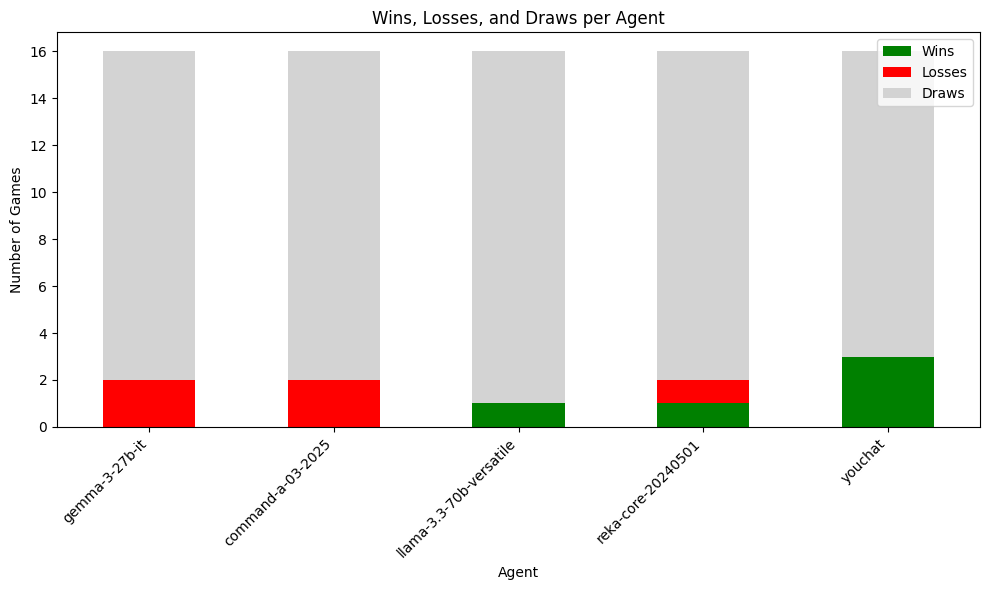

In [35]:
results_df = pd.DataFrame.from_dict(results_per_agent, orient='index')

results_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'red', 'lightgray'])
plt.title('Wins, Losses, and Draws per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.legend(['Wins', 'Losses', 'Draws'])
plt.tight_layout()
plt.show()

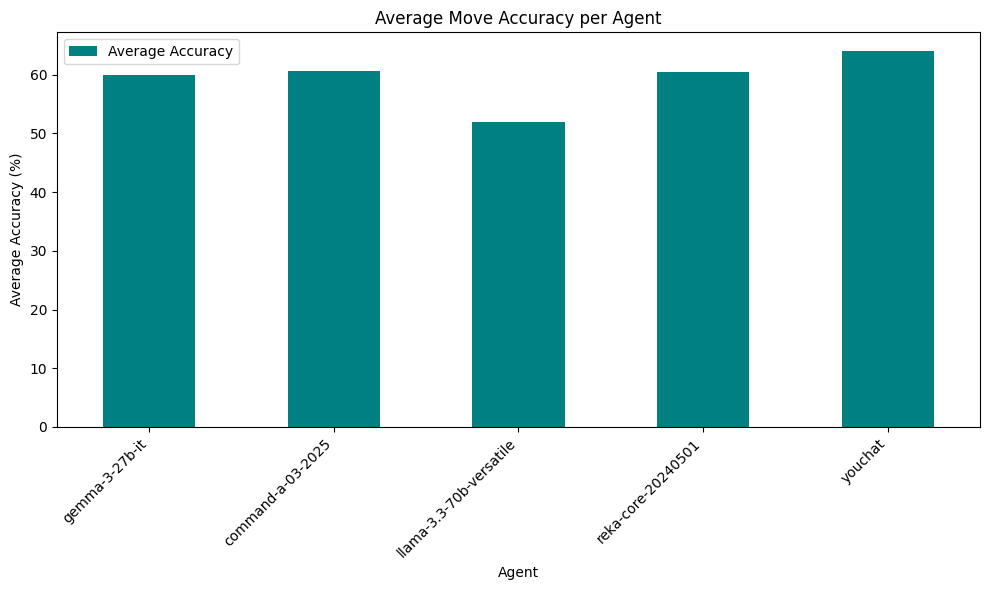

In [36]:
accuracy_df = pd.DataFrame.from_dict(agent_accuracy, orient='index', columns=['Average Accuracy'])

accuracy_df.plot(kind='bar', figsize=(10, 6), color='teal')
plt.title('Average Move Accuracy per Agent')
plt.xlabel('Agent')
plt.ylabel('Average Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

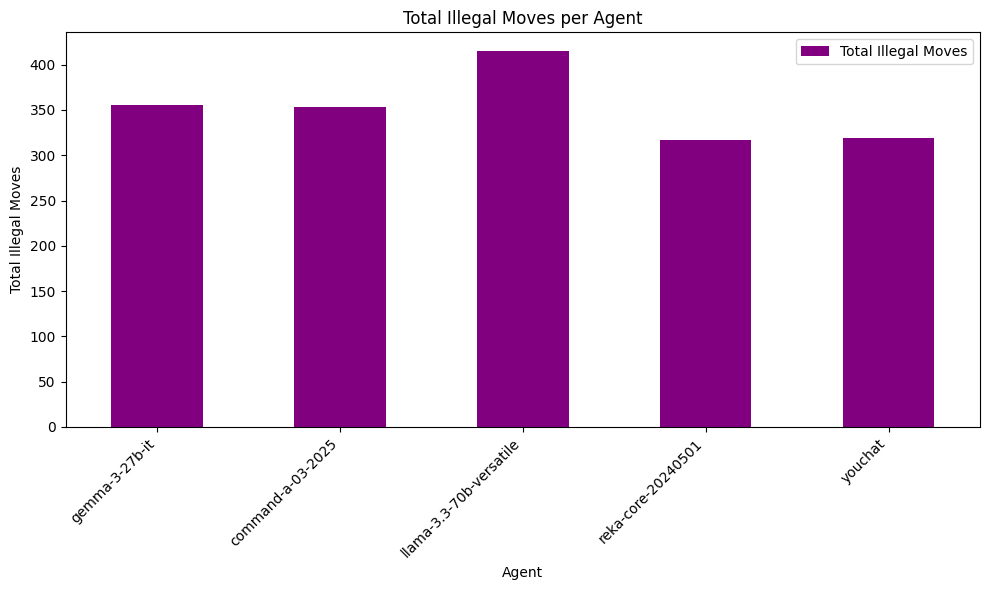

In [37]:
illegal_moves_df = pd.DataFrame.from_dict(illegal_moves_per_agent, orient='index', columns=['Total Illegal Moves'])

illegal_moves_df.plot(kind='bar', figsize=(10, 6), color='purple')
plt.title('Total Illegal Moves per Agent')
plt.xlabel('Agent')
plt.ylabel('Total Illegal Moves')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [38]:
max_illegal_streak_per_agent = {agent: 0 for agent in all_agents}

for agent in all_agents:
    white_streak_sum = data[data['white'] == agent]['white_illegal_streak_max'].sum()
    black_streak_sum = data[data['black'] == agent]['black_illegal_streak_max'].sum()
    max_illegal_streak_per_agent[agent] = white_streak_sum + black_streak_sum

table_data_max_illegal_streak = []
for agent, total_streak in max_illegal_streak_per_agent.items():
    table_data_max_illegal_streak.append([agent, total_streak])

print("Maximum Illegal Move Streak per Agent:")
print(tabulate.tabulate(table_data_max_illegal_streak, headers=['Agent', 'Maximum Illegal Move Streak']))

Maximum Illegal Move Streak per Agent:
Agent                      Maximum Illegal Move Streak
-----------------------  -----------------------------
gemma-3-27b-it                                      65
command-a-03-2025                                   72
llama-3.3-70b-versatile                             38
reka-core-20240501                                  56
youchat                                             46


In [39]:
random_fallbacks_per_agent = {agent: 0 for agent in all_agents}

for agent in all_agents:
    white_fallback_sum = data[data['white'] == agent]['white_random_fallbacks'].sum()
    black_fallback_sum = data[data['black'] == agent]['black_random_fallbacks'].sum()
    random_fallbacks_per_agent[agent] = white_fallback_sum + black_fallback_sum

table_data_random_fallbacks = []
for agent, total_fallbacks in random_fallbacks_per_agent.items():
    table_data_random_fallbacks.append([agent, total_fallbacks])

print("Total Random Fallbacks per Agent:")
print(tabulate.tabulate(table_data_random_fallbacks, headers=['Agent', 'Total Random Fallbacks']))

Total Random Fallbacks per Agent:
Agent                      Total Random Fallbacks
-----------------------  ------------------------
gemma-3-27b-it                                  6
command-a-03-2025                              17
llama-3.3-70b-versatile                         3
reka-core-20240501                              1
youchat                                         2


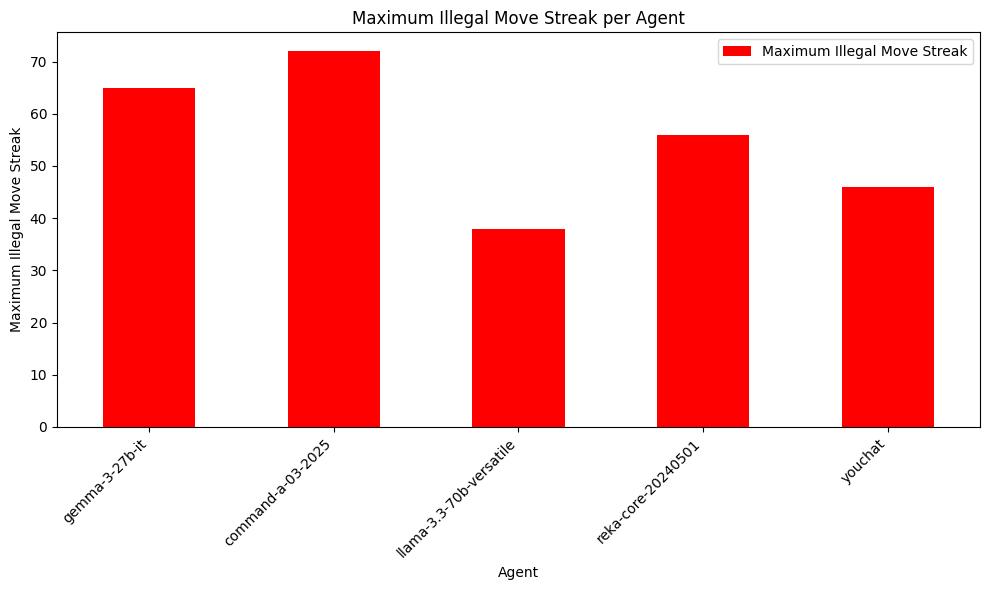

In [40]:
max_illegal_streak_df = pd.DataFrame.from_dict(max_illegal_streak_per_agent, orient='index', columns=['Maximum Illegal Move Streak'])

max_illegal_streak_df.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Maximum Illegal Move Streak per Agent')
plt.xlabel('Agent')
plt.ylabel('Maximum Illegal Move Streak')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

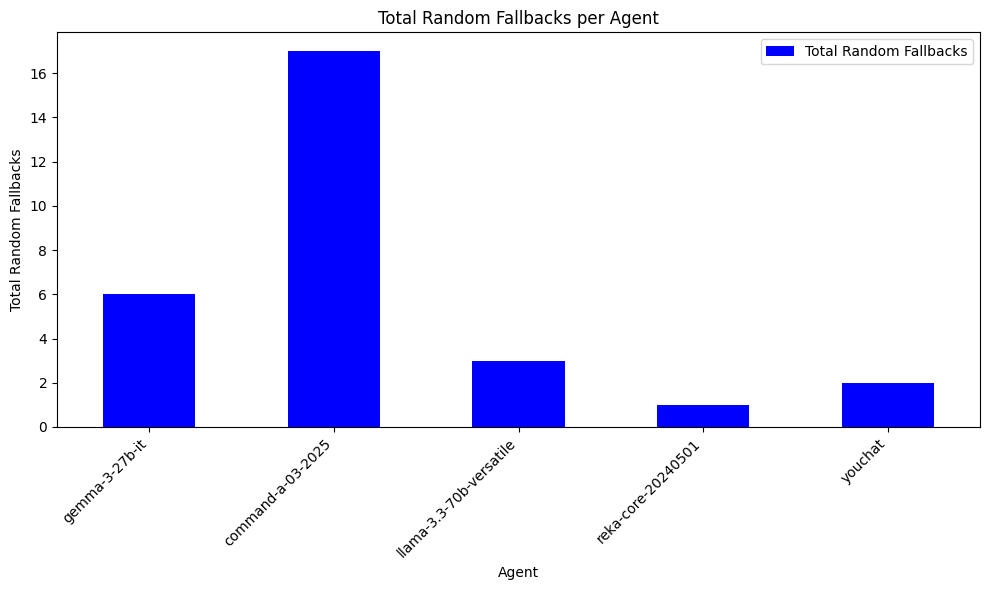

In [41]:
random_fallbacks_df = pd.DataFrame.from_dict(random_fallbacks_per_agent, orient='index', columns=['Total Random Fallbacks'])

random_fallbacks_df.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Total Random Fallbacks per Agent')
plt.xlabel('Agent')
plt.ylabel('Total Random Fallbacks')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Povezanost s degradacijom konteksta LLM-a

Metrike poput **ukupnog broja ilegalnih poteza**, **maksimalnog niza ilegalnih poteza**, i **ukupnog broja nasumičnih fallback poteza** pružaju uvid u to kako se LLM (Large Language Model) agenti nose s kompleksnošću i konzistentnošću šahovskih partija, što se može izravno povezati s degradacijom konteksta.

*   **Ukupan broj ilegalnih poteza i maksimalni niz ilegalnih poteza**: Visok broj ilegalnih poteza ili dugi niz ilegalnih poteza kod nekog agenta može ukazivati na to da agent gubi "razumijevanje" pravila igre ili trenutnog stanja ploče. Ovo se može dogoditi kada je kontekst predug ili kada LLM ne može učinkovito pratiti sve promjene na ploči i primijeniti šahovska pravila. Degradacija konteksta znači da LLM teže pristupa ili interpretira ranije informacije u partiji, što rezultira nelogičnim ili nevažećim potezima.

*   **Ukupan broj nasumičnih fallback poteza**: `random_fallbacks` (nasumični fallback potezi) su kritičan pokazatelj. Oni impliciraju da se agent nije mogao odlučiti za validan ili "pametan" potez na temelju svog modela i raspoloživog konteksta, pa je sustav umjesto njega odigrao nasumičnan legalan potez. Ovo je jasan signal degradacije konteksta ili neuspjeha u održavanju koherentnosti. U idealnom scenariju, LLM bi trebao generirati smislene i strateške poteze, a ne nasumične.

Zajedno, ove metrike sugeriraju da agenti koji pokazuju veću učestalost ilegalnih i nasumičnih poteza vjerojatno pate od veće degradacije konteksta. To ih sprječava da održavaju dugoročnu strategiju, točno interpretiraju trenutno stanje igre i pridržavaju se osnovnih pravila, što je ključno za uspješno igranje šaha.

# Evaluacija kvalitete poteza

In [42]:
move_quality_metrics = {agent: {'brilliant_moves': 0, 'best_moves': 0, 'excellent_moves': 0, 'inaccuracies': 0, 'mistakes': 0, 'blunders': 0} for agent in all_agents}

for agent in all_agents:
    # Brilliant Moves
    white_brilliant_sum = data[data['white'] == agent]['white_brilliant_moves'].sum()
    black_brilliant_sum = data[data['black'] == agent]['black_brilliant_moves'].sum()
    move_quality_metrics[agent]['brilliant_moves'] = white_brilliant_sum + black_brilliant_sum

    # Best Moves
    white_best_sum = data[data['white'] == agent]['white_best_moves'].sum()
    black_best_sum = data[data['black'] == agent]['black_best_moves'].sum()
    move_quality_metrics[agent]['best_moves'] = white_best_sum + black_best_sum

    # Excellent Moves
    white_excellent_sum = data[data['white'] == agent]['white_excellent_moves'].sum()
    black_excellent_sum = data[data['black'] == agent]['black_excellent_moves'].sum()
    move_quality_metrics[agent]['excellent_moves'] = white_excellent_sum + black_excellent_sum

    # Inaccuracies
    white_inaccuracies_sum = data[data['white'] == agent]['white_inaccuracies'].sum()
    black_inaccuracies_sum = data[data['black'] == agent]['black_inaccuracies'].sum()
    move_quality_metrics[agent]['inaccuracies'] = white_inaccuracies_sum + black_inaccuracies_sum

    # Mistakes
    white_mistakes_sum = data[data['white'] == agent]['white_mistakes'].sum()
    black_mistakes_sum = data[data['black'] == agent]['black_mistakes'].sum()
    move_quality_metrics[agent]['mistakes'] = white_mistakes_sum + black_mistakes_sum

    # Blunders
    white_blunders_sum = data[data['white'] == agent]['white_blunders'].sum()
    black_blunders_sum = data[data['black'] == agent]['black_blunders'].sum()
    move_quality_metrics[agent]['blunders'] = white_blunders_sum + black_blunders_sum

table_data_move_quality = []
headers_move_quality = ['Agent'] + list(next(iter(move_quality_metrics.values())).keys())
for agent, metrics in move_quality_metrics.items():
    table_data_move_quality.append([agent] + list(metrics.values()))

print("Move Quality Metrics per Agent:")
print(tabulate.tabulate(table_data_move_quality, headers=headers_move_quality))

Move Quality Metrics per Agent:
Agent                      brilliant_moves    best_moves    excellent_moves    inaccuracies    mistakes    blunders
-----------------------  -----------------  ------------  -----------------  --------------  ----------  ----------
gemma-3-27b-it                           0            26                 39              69          38         128
command-a-03-2025                        1            34                 51              53          45          83
llama-3.3-70b-versatile                  0            47                 63              67         103         230
reka-core-20240501                       0            36                 46              49          65         118
youchat                                  1            65                 84              48          62         127


In [43]:
move_quality_df = pd.DataFrame.from_dict(move_quality_metrics, orient='index')

print("Move Quality Metrics DataFrame:")
print(move_quality_df)

Move Quality Metrics DataFrame:
                         brilliant_moves  best_moves  excellent_moves  \
gemma-3-27b-it                         0          26               39   
command-a-03-2025                      1          34               51   
llama-3.3-70b-versatile                0          47               63   
reka-core-20240501                     0          36               46   
youchat                                1          65               84   

                         inaccuracies  mistakes  blunders  
gemma-3-27b-it                     69        38       128  
command-a-03-2025                  53        45        83  
llama-3.3-70b-versatile            67       103       230  
reka-core-20240501                 49        65       118  
youchat                            48        62       127  


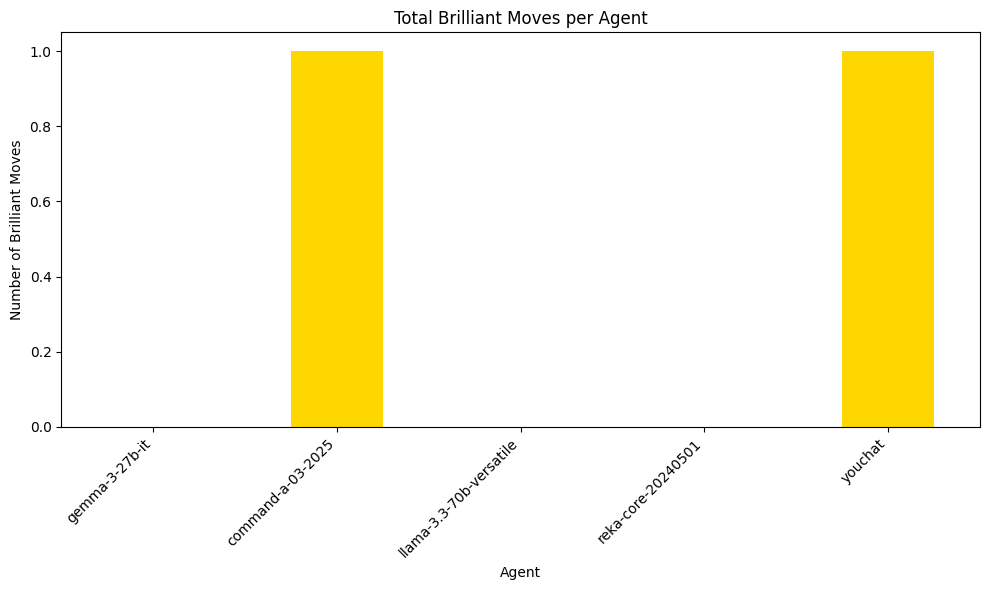

In [44]:
move_quality_df['brilliant_moves'].plot(kind='bar', figsize=(10, 6), color='gold')
plt.title('Total Brilliant Moves per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Brilliant Moves')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

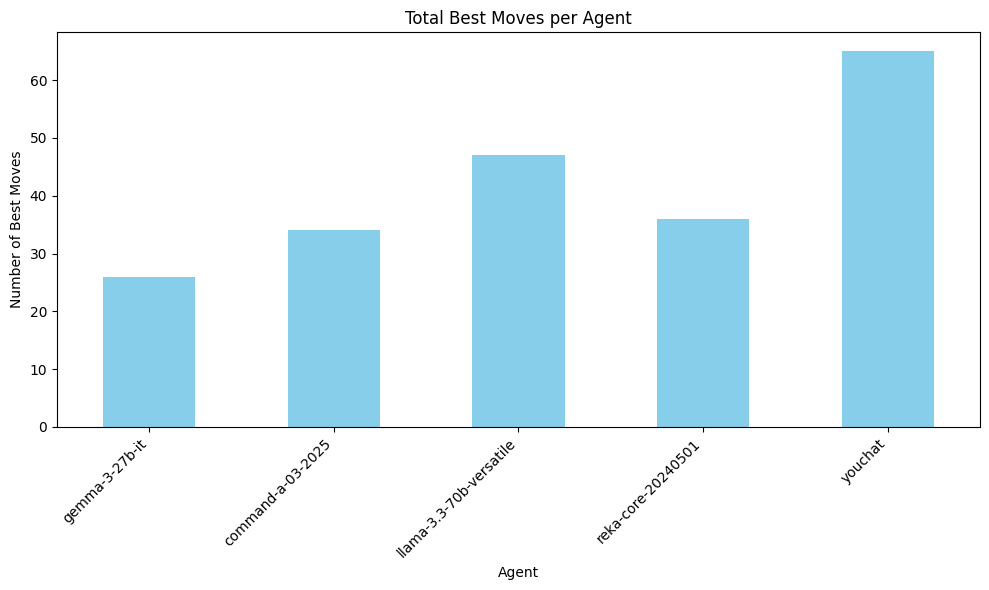

In [ ]:
move_quality_data['best_moves'].plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Total Best Moves per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Best Moves')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

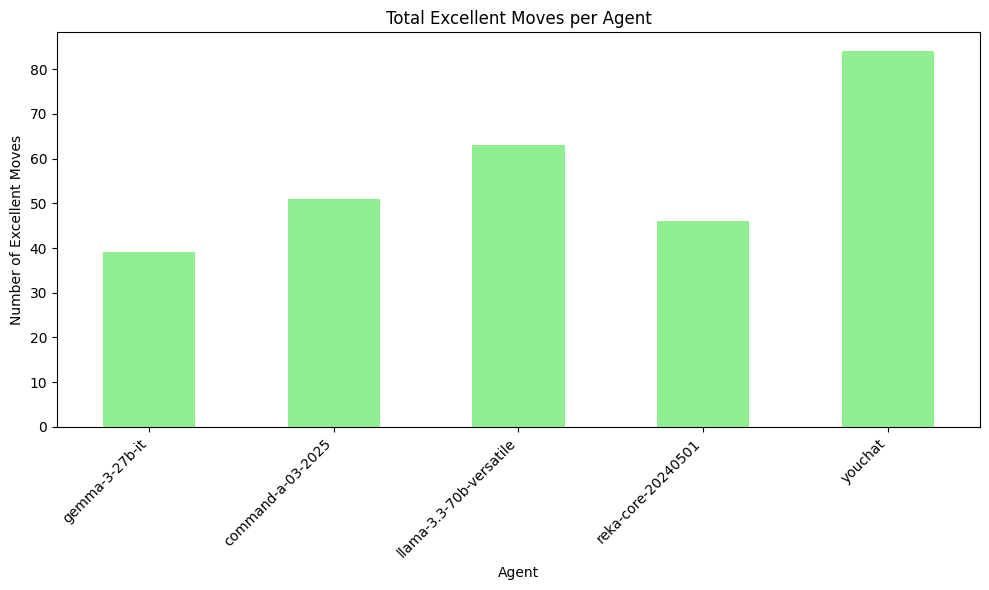

In [46]:
move_quality_df['excellent_moves'].plot(kind='bar', figsize=(10, 6), color='lightgreen')
plt.title('Total Excellent Moves per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Excellent Moves')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

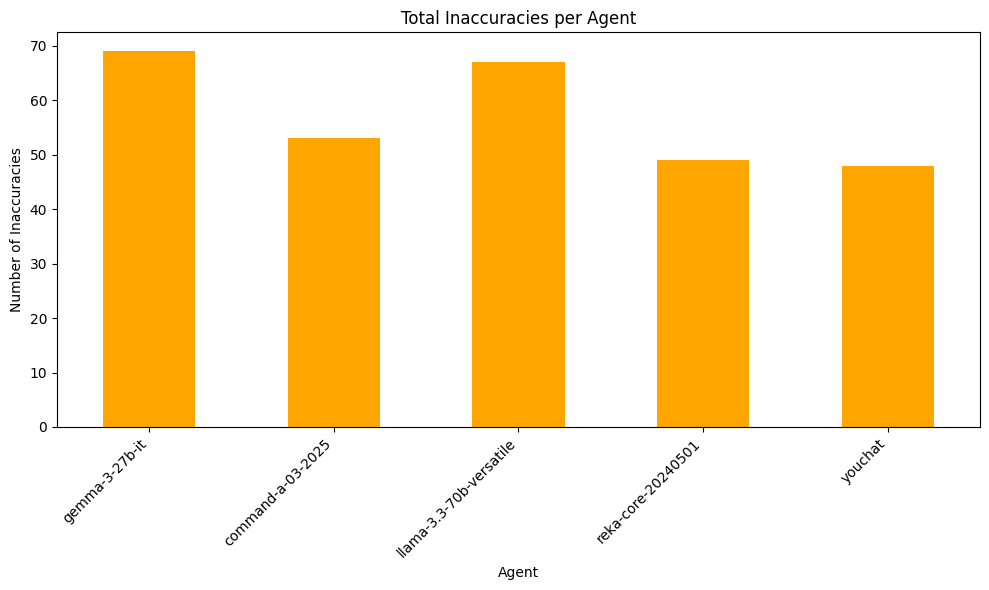

In [47]:
move_quality_df['inaccuracies'].plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Total Inaccuracies per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Inaccuracies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

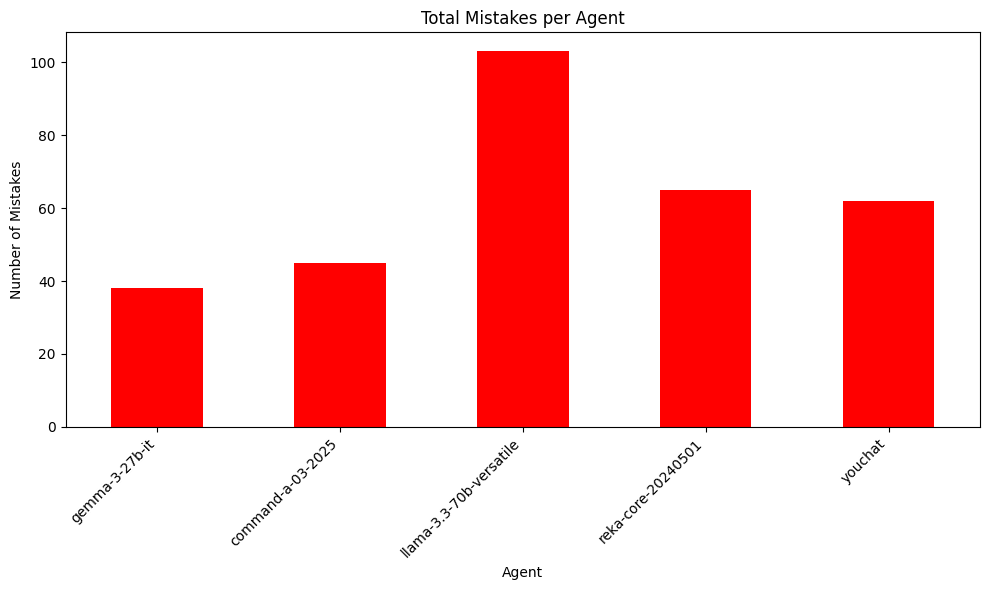

In [48]:
move_quality_df['mistakes'].plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Total Mistakes per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Mistakes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

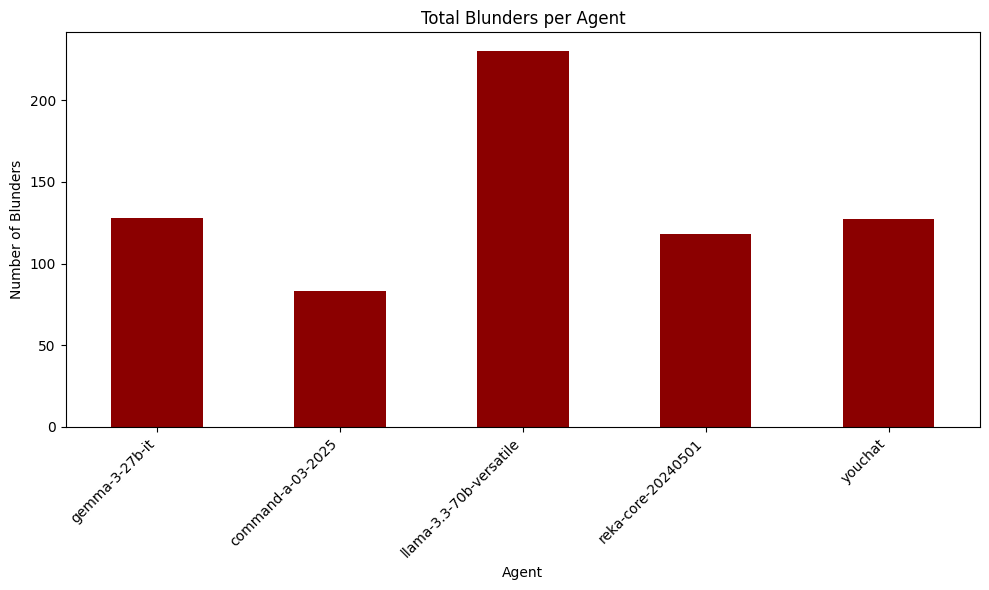

In [49]:
move_quality_df['blunders'].plot(kind='bar', figsize=(10, 6), color='darkred')
plt.title('Total Blunders per Agent')
plt.xlabel('Agent')
plt.ylabel('Number of Blunders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Usporedba kvalitete poteza (bijeli vs. crni)

In [50]:
white_vs_black_moves = {
    'brilliant_moves': {
        'white': data['white_brilliant_moves'].sum(),
        'black': data['black_brilliant_moves'].sum()
    },
    'best_moves': {
        'white': data['white_best_moves'].sum(),
        'black': data['black_best_moves'].sum()
    },
    'excellent_moves': {
        'white': data['white_excellent_moves'].sum(),
        'black': data['black_excellent_moves'].sum()
    },
    'inaccuracies': {
        'white': data['white_inaccuracies'].sum(),
        'black': data['black_inaccuracies'].sum()
    },
    'mistakes': {
        'white': data['white_mistakes'].sum(),
        'black': data['black_mistakes'].sum()
    },
    'blunders': {
        'white': data['white_blunders'].sum(),
        'black': data['black_blunders'].sum()
    }
}

white_vs_black_df = pd.DataFrame.from_dict(white_vs_black_moves, orient='index')

print("Move Quality Comparison: White vs. Black:")
print(tabulate.tabulate(white_vs_black_df, headers='keys', tablefmt='pretty'))

Move Quality Comparison: White vs. Black:
+-----------------+-------+-------+
|                 | white | black |
+-----------------+-------+-------+
| brilliant_moves |   1   |   1   |
|   best_moves    |  109  |  99   |
| excellent_moves |  150  |  133  |
|  inaccuracies   |  145  |  141  |
|    mistakes     |  154  |  159  |
|    blunders     |  336  |  350  |
+-----------------+-------+-------+


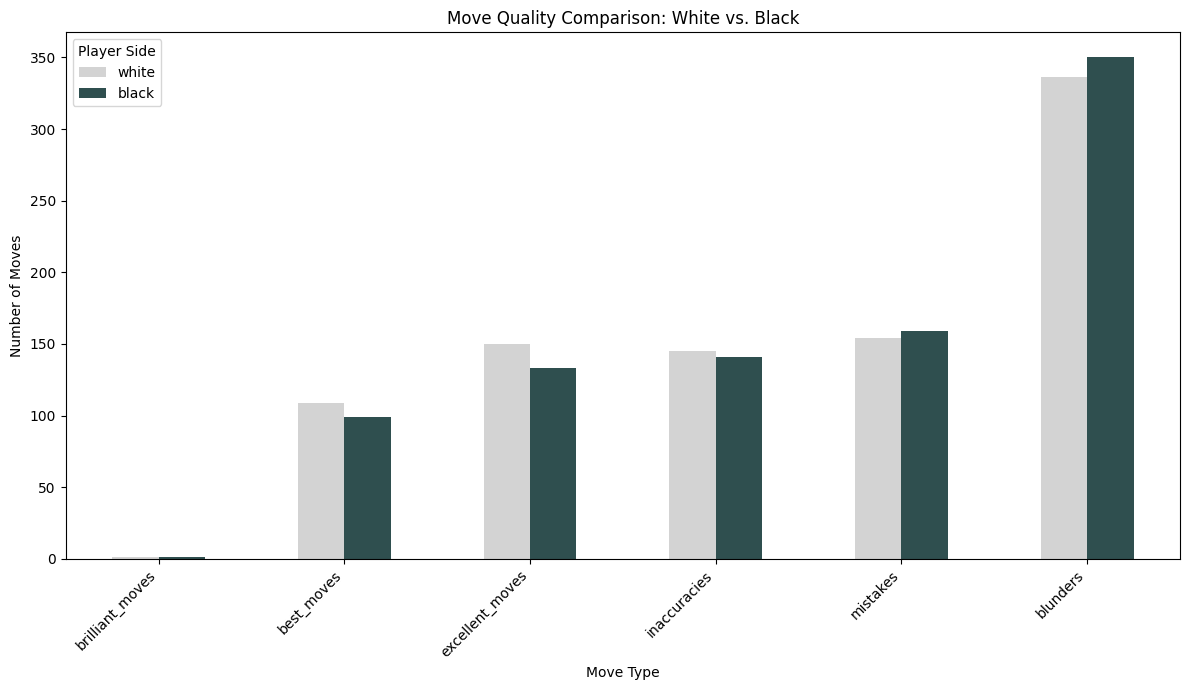

In [51]:
white_vs_black_df.plot(kind='bar', figsize=(12, 7), color=['lightgray', 'darkslategray'])
plt.title('Move Quality Comparison: White vs. Black')
plt.xlabel('Move Type')
plt.ylabel('Number of Moves')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Player Side')
plt.tight_layout()
plt.show()

### Distribucija kvalitete poteza po agentu

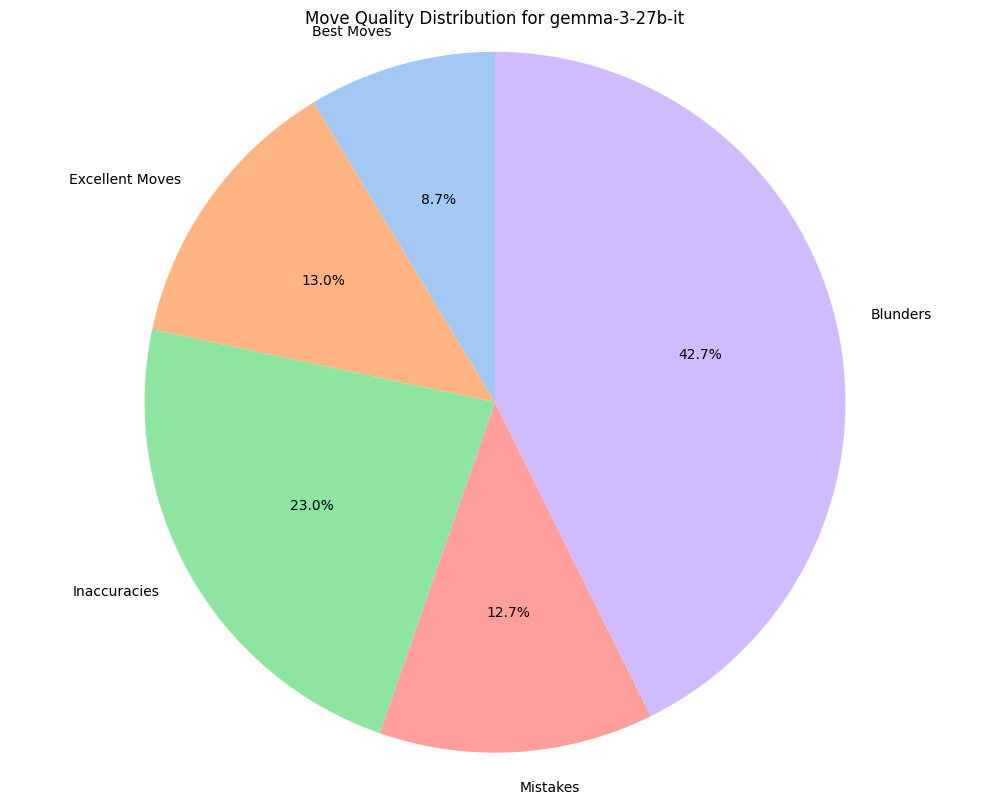

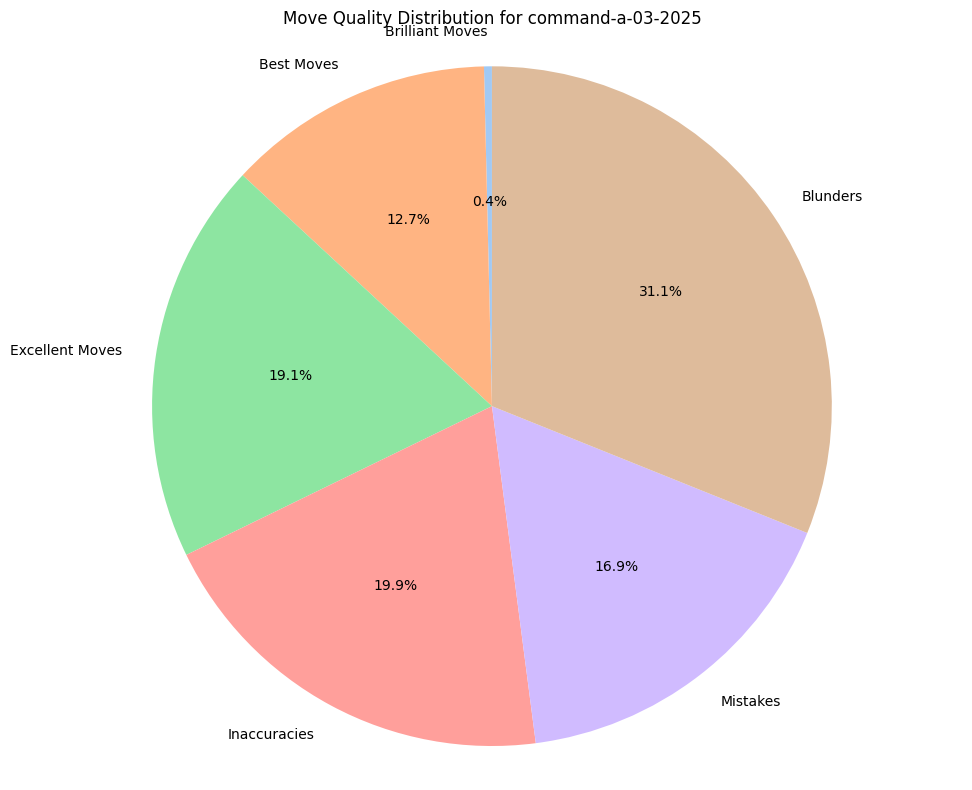

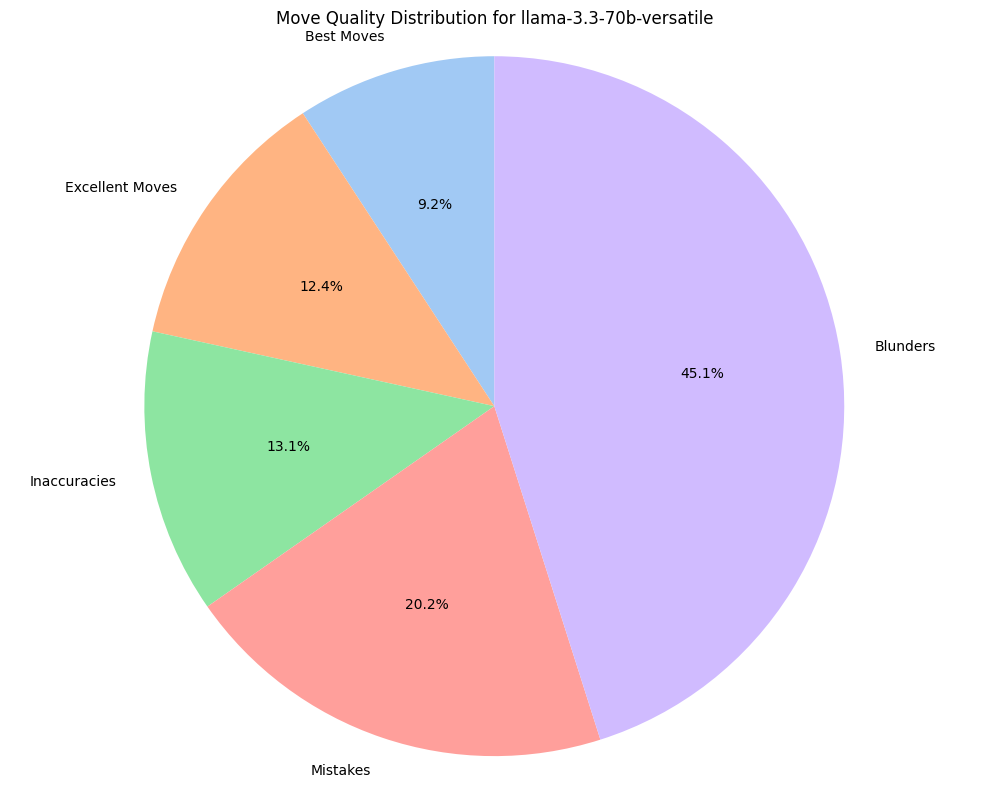

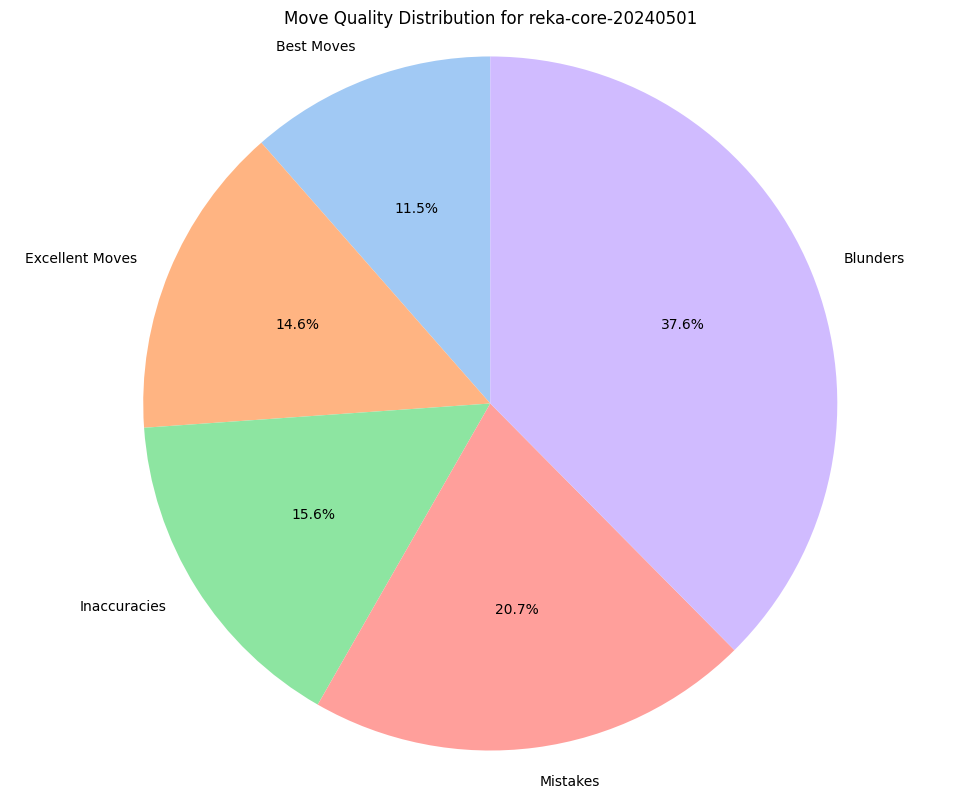

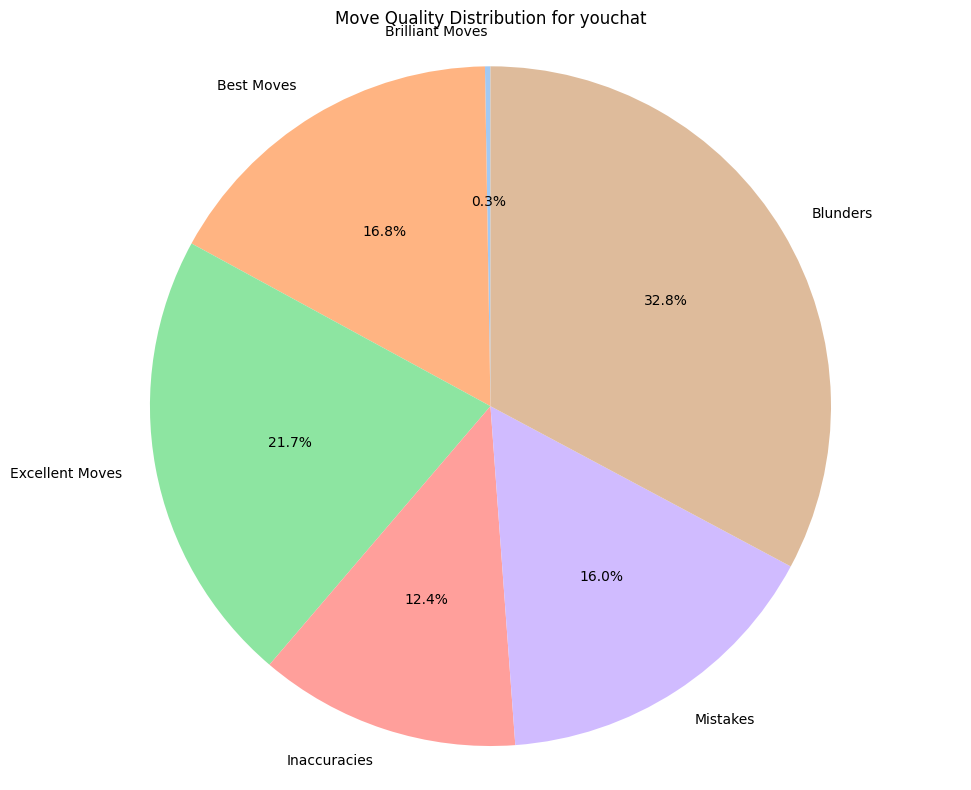

In [52]:
for agent in all_agents:
    agent_move_quality = move_quality_df.loc[agent, ['brilliant_moves', 'best_moves', 'excellent_moves', 'inaccuracies', 'mistakes', 'blunders']]

    # Filter out zero values to avoid empty slices in the pie chart for categories with no moves
    agent_move_quality = agent_move_quality[agent_move_quality > 0]

    if not agent_move_quality.empty:
        plt.figure(figsize=(10, 8))
        plt.pie(agent_move_quality, labels=agent_move_quality.index.str.replace('_', ' ').str.title(), autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
        plt.title(f'Move Quality Distribution for {agent}')
        plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.tight_layout()
        plt.show()
    else:
        print(f"No move quality data to display for {agent}")

### Distribucija kvalitete poteza (ukupno)

In [53]:
total_move_quality = move_quality_df[['brilliant_moves', 'best_moves', 'excellent_moves', 'inaccuracies', 'mistakes', 'blunders']].sum()

print("Total Move Quality Distribution Across All Agents:")
print(tabulate.tabulate(total_move_quality.reset_index(), headers=['Move Type', 'Count'], tablefmt='pretty'))

Total Move Quality Distribution Across All Agents:
+---+-----------------+-------+
|   |    Move Type    | Count |
+---+-----------------+-------+
| 0 | brilliant_moves |   2   |
| 1 |   best_moves    |  208  |
| 2 | excellent_moves |  283  |
| 3 |  inaccuracies   |  286  |
| 4 |    mistakes     |  313  |
| 5 |    blunders     |  686  |
+---+-----------------+-------+


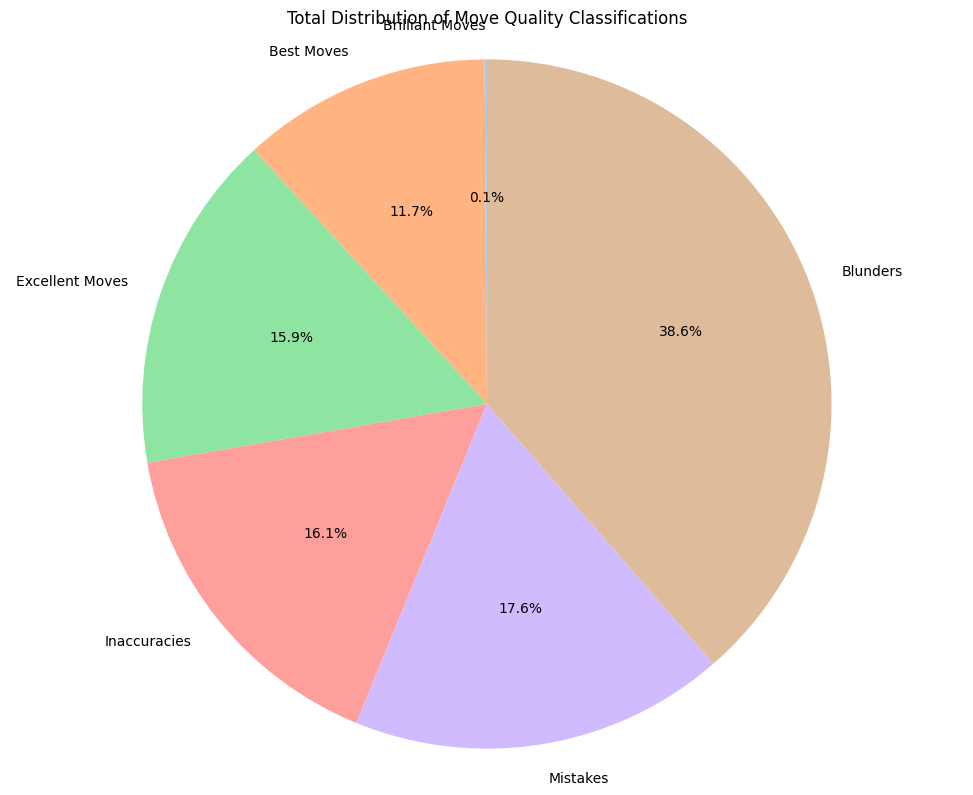

In [54]:
plt.figure(figsize=(10, 8))
plt.pie(total_move_quality, labels=total_move_quality.index.str.replace('_', ' ').str.title(), autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Total Distribution of Move Quality Classifications')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [61]:

white_fallbacks = (
    data.groupby("white")["white_random_fallbacks"]
    .sum()
    .rename("fallbacks_as_white")
)

black_fallbacks = (
    data.groupby("black")["black_random_fallbacks"]
    .sum()
    .rename("fallbacks_as_black")
)

fallback_distribution = pd.concat(
    [white_fallbacks, black_fallbacks],
    axis=1
).fillna(0)

fallback_distribution["total_fallbacks"] = (
    fallback_distribution["fallbacks_as_white"]
    + fallback_distribution["fallbacks_as_black"]
)

fallback_distribution


,fallbacks_as_white,fallbacks_as_black,total_fallbacks
command-a-03-2025,0,17,17
gemma-3-27b-it,6,0,6
llama-3.3-70b-versatile,3,0,3
reka-core-20240501,0,1,1
youchat,2,0,2


In [63]:
data['white_random_fallbacks'].value_counts()

white_random_fallbacks
0    35
1     2
2     2
5     1
Name: count, dtype: int64

In [64]:
data['black_random_fallbacks'].value_counts()

black_random_fallbacks
0    32
1     4
2     2
5     2
Name: count, dtype: int64

In [79]:
falbacks = data['white_random_fallbacks'].sum() + data['black_random_fallbacks'].sum()

white_eval_cols = [
    "white_brilliant_moves",
    "white_critical_moves",
    "white_best_moves",
    "white_excellent_moves",
    "white_ok_moves",
    "white_inaccuracies",
    "white_mistakes",
    "white_blunders",
    "white_theoretical_moves",
]

black_eval_cols = [
    "black_brilliant_moves",
    "black_critical_moves",
    "black_best_moves",
    "black_excellent_moves",
    "black_ok_moves",
    "black_inaccuracies",
    "black_mistakes",
    "black_blunders",
    "black_theoretical_moves",
]

total_moves = (
    data[white_eval_cols].sum().sum()
    + data[black_eval_cols].sum().sum()
)

print(f"Fallback percentage: {falbacks / total_moves if total_moves > 0 else 0:.4f}%")

Fallback percentage: 0.0131%


np.int64(2218)

# Distribucija otvaranja

In [55]:
opening_distribution = data['opening'].value_counts()

print("Distribution of Chess Openings:")
print(tabulate.tabulate(opening_distribution.reset_index(), headers=['Opening', 'Count'], tablefmt='pretty'))

Distribution of Chess Openings:
+---+--------------------------------+-------+
|   |            Opening             | Count |
+---+--------------------------------+-------+
| 0 |        Petrov's Defence        |  11   |
| 1 |     King's Knight Opening      |   8   |
| 2 |        King's Pawn Game        |   6   |
| 3 |           Bongcloud            |   5   |
| 4 |        English Opening         |   3   |
| 5 |      Scandinavian Defence      |   2   |
| 6 |          Centre Game           |   2   |
| 7 | Petrov's Defence Modern Attack |   2   |
| 8 | Vienna Game Falkbeer variation |   1   |
+---+--------------------------------+-------+


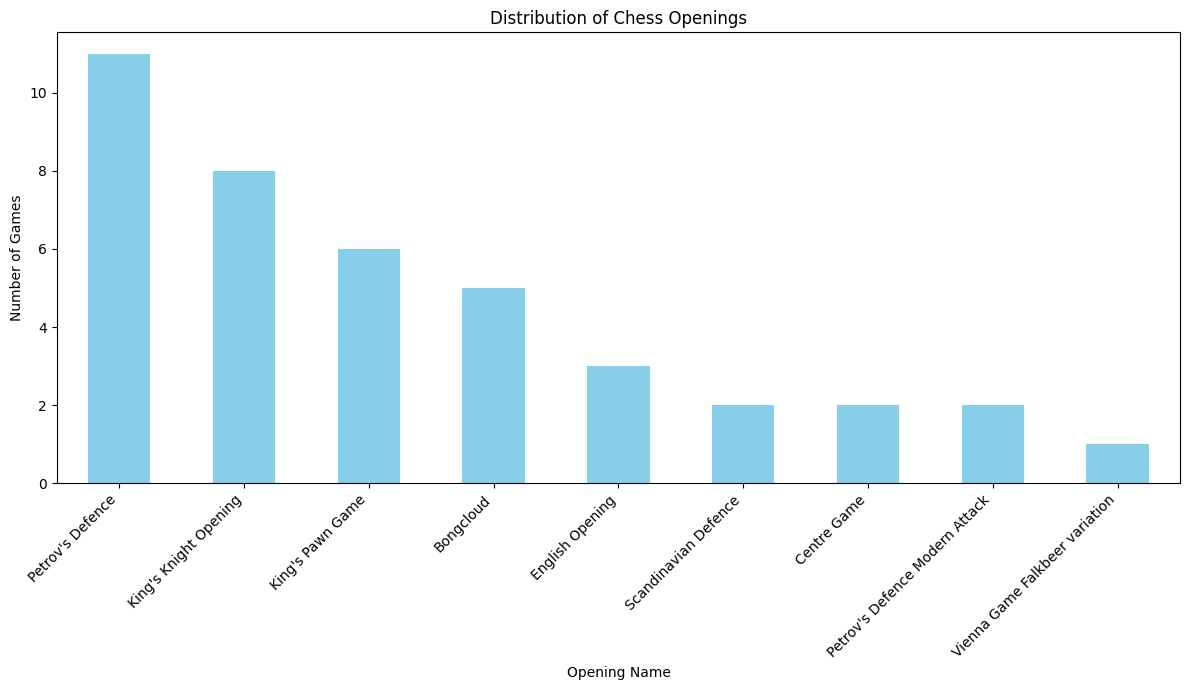

In [56]:
plt.figure(figsize=(12, 7))
opening_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Chess Openings')
plt.xlabel('Opening Name')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [57]:
opening_wins = {}

for index, row in data.iterrows():
    opening = row['opening']
    result = row['result']

    if opening not in opening_wins:
        opening_wins[opening] = {'wins': 0, 'games': 0}

    opening_wins[opening]['games'] += 1
    if result == '1-0' or result == '0-1':
        opening_wins[opening]['wins'] += 1

opening_wins_df = pd.DataFrame.from_dict(opening_wins, orient='index')
opening_wins_df = opening_wins_df.sort_values(by='wins', ascending=False)

print("Number of wins per opening:")
print(tabulate.tabulate(opening_wins_df, headers='keys', tablefmt='pretty'))

most_winning_opening = opening_wins_df.index[0]
max_wins = opening_wins_df['wins'].max()

print(f"\nOpening with the most wins: '{most_winning_opening}' with {max_wins} wins.")

Number of wins per opening:
+--------------------------------+------+-------+
|                                | wins | games |
+--------------------------------+------+-------+
|           Bongcloud            |  2   |   5   |
|        Petrov's Defence        |  1   |  11   |
|      Scandinavian Defence      |  1   |   2   |
|     King's Knight Opening      |  1   |   8   |
|        King's Pawn Game        |  0   |   6   |
|          Centre Game           |  0   |   2   |
|        English Opening         |  0   |   3   |
| Petrov's Defence Modern Attack |  0   |   2   |
| Vienna Game Falkbeer variation |  0   |   1   |
+--------------------------------+------+-------+

Opening with the most wins: 'Bongcloud' with 2 wins.


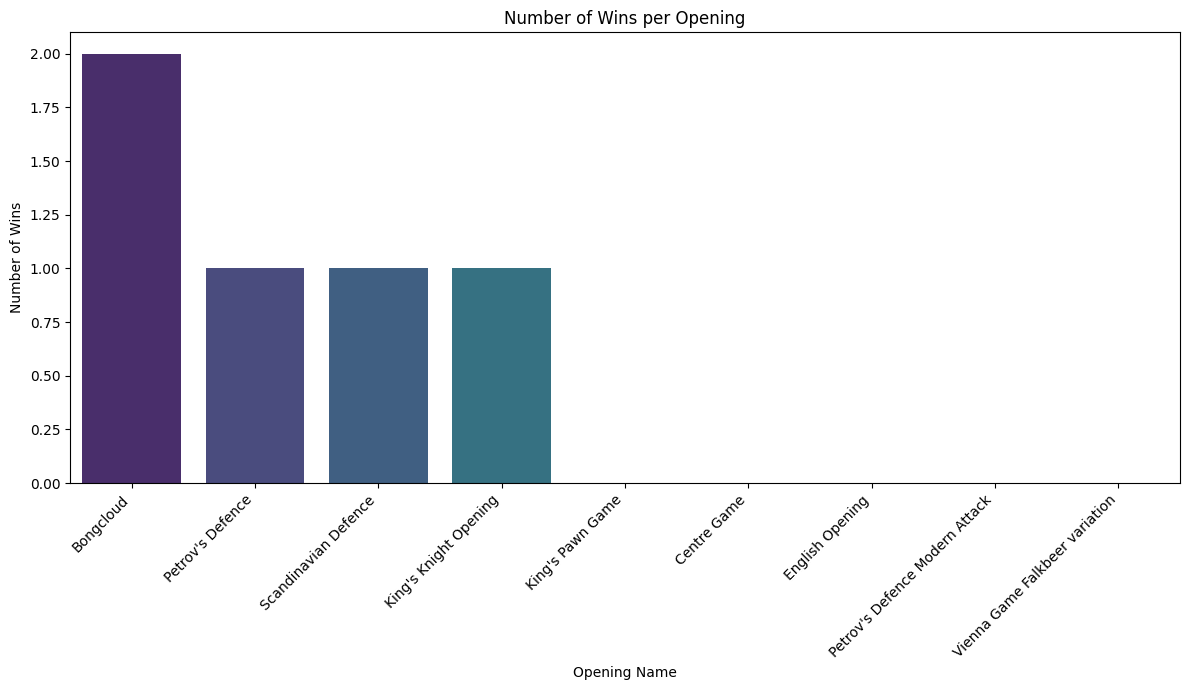

In [58]:
plt.figure(figsize=(12, 7))
sns.barplot(x=opening_wins_df.index, y=opening_wins_df['wins'], palette='viridis', hue=opening_wins_df.index)
plt.title('Number of Wins per Opening')
plt.xlabel('Opening Name')
plt.ylabel('Number of Wins')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Chess.com analiza

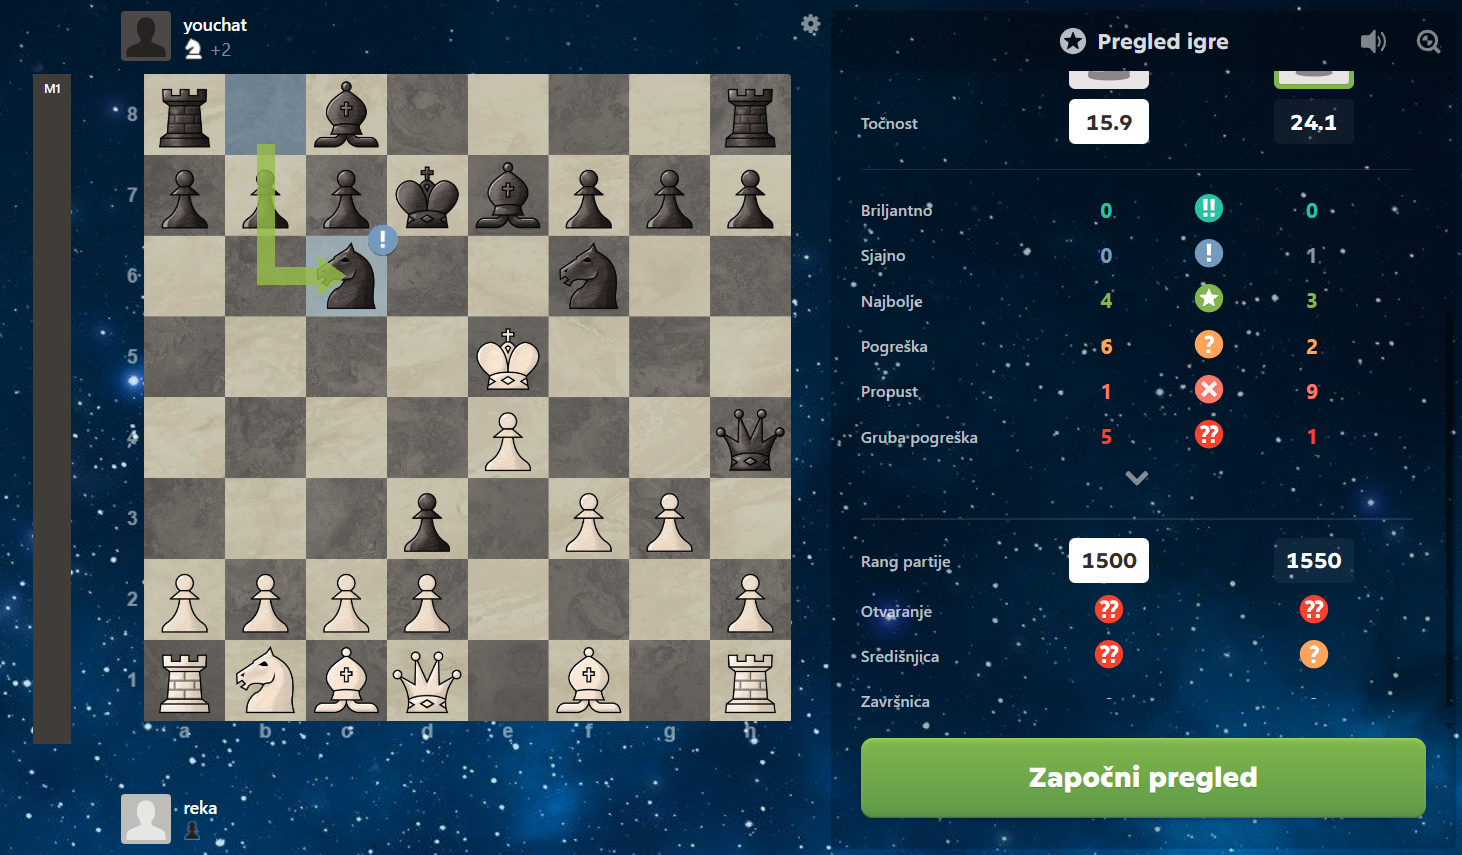

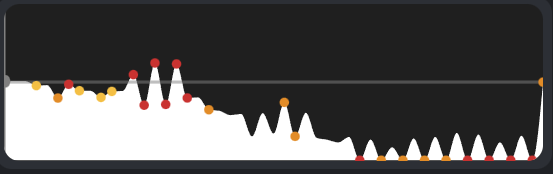

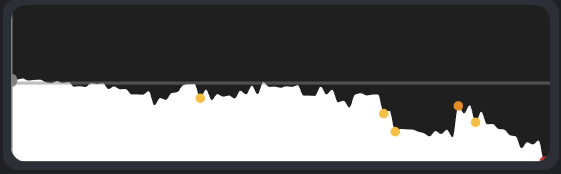

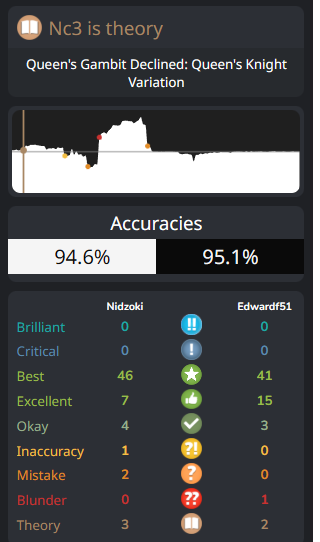!

# Stranica korištena za analizu

[Wintrchess analiza](https://wintrchess.com/analysis)

# Primjeri partija sa turnira

[Event "AI Chess Match"]
[Site "?"]
[Date "2026.01.29"]
[Round "?"]
[White "reka"]
[Black "youchat"]
[Result "0-1"]

1. e4 e5 2. Ke2 d5 3. Ke3 Qh4 4. f3 d4+ 5. Ke2 d3+ 6. Ke3 Be7 7. Ne2 Nf6 8. Nd4 Kd8 9. g3 exd4+ 10. Kxd4 Kd7 11. Ke5 Nc6+ 12. Kf5 Rg8 13. e5 Rh8 14. Qe2 Rg8 15. Qe4 Rh8 16. Qd5+ Bd6 17. Qe6+ Kd8 18. g4 Ng8 19. Qd7+ Kxd7 20. exd6 Nf6 21. f4 Rg8 22. c4 Rh8 23. Bxd3 Rg8 24. Be4 Kxd6# 0-1



[Event "AI Chess Match"]
[Site "?"]
[Date "2026.01.29"]
[Round "?"]
[White "reka"]
[Black "cohere"]
[Result "1-0"]

1. e4 e5 2. Ke2 Nf6 3. d4 Be7 4. d5 g6 5. Ke3 Bc5+ 6. Ke2 O-O 7. Kf3 Kh8 8. Qd3 Nxe4 9. Qxe4 Qh4 10. g4 Kg8 11. Qxe5 Bd4 12. Qe8 Kh8 13. Qxf8# 1-0

